In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [2]:
name_dataset = 'puteshestvi'

### load data

In [3]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(8245, 7)
CPU times: user 1.39 s, sys: 33.8 ms, total: 1.42 s
Wall time: 1.44 s


In [4]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/grecha/,NaN,Россия,Россияне автостопом добрались до Эмиратов,В Объединенные Арабские Эмираты (ОАЭ) в среду ...,Путешествия
1,1999-10-22 12:00:00,https://lenta.ru/news/1999/10/22/kazan/,NaN,Экономика,Казанский аэропорт вышел на мировой уровень,Торжественная церемония открытия взлетно-посад...,Путешествия


### preprocess

* get dates

In [5]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 86.2 ms, sys: 678 µs, total: 86.9 ms
Wall time: 91.6 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [6]:
import preprocessing_tools as pr

In [7]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 1.34 s, sys: 7.01 ms, total: 1.35 s
Wall time: 1.35 s


In [8]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/grecha/,NaN,Россия,Россияне автостопом добрались до Эмиратов,в объединенные арабские эмираты оаэ в среду пр...,Путешествия,"[(1999, 10, 06)]",1999,10
1,1999-10-22 12:00:00,https://lenta.ru/news/1999/10/22/kazan/,NaN,Экономика,Казанский аэропорт вышел на мировой уровень,торжественная церемония открытия взлетнопосадо...,Путешествия,"[(1999, 10, 22)]",1999,10


* cleanedNames

In [9]:
from cleanedNames import KeyProc
cn = KeyProc()

In [10]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 13.4 s, sys: 22.7 ms, total: 13.4 s
Wall time: 13.4 s


* lemmatization

In [11]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 30.1 s, sys: 62.8 ms, total: 30.2 s
Wall time: 30.2 s


* add docID

In [12]:
df['docID'] = list(range(df.shape[0]))

In [13]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[объединить, арабский, эмират, оаэ, прибыть, р..."
1,1,1999,10,"[торжественный, церемония, открытие, взлетнопо..."


In [14]:
print(df.shape)
df.isnull().sum()

(8245, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [15]:
df.year.min()

1999

## model

* prepare

In [16]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 99.2 ms, sys: 19.7 ms, total: 119 ms
Wall time: 121 ms


In [17]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [18]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/puteshestvi", num_batches=9)
CPU times: user 3.63 s, sys: 251 ms, total: 3.88 s
Wall time: 1.56 s


In [19]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [20]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=7c381974-65e9-4e45-9478-74cccffcac6b, num_entries=7824)

In [25]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [29]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.12807762622833252
	SparsityPhiScore: 0.24196621775627136
	PerplexityScore: 2952.2138671875
	time: 0:00:07.245750
#topic 3.........
	SparsityThetaScore: 0.2863149344921112
	SparsityPhiScore: 0.3656378388404846
	PerplexityScore: 2596.471923828125
	time: 0:00:07.433727
#topic 4.........
	SparsityThetaScore: 0.3776834309101105
	SparsityPhiScore: 0.4375714361667633
	PerplexityScore: 2400.96337890625
	time: 0:00:07.635237
#topic 5.........
	SparsityThetaScore: 0.4353668987751007
	SparsityPhiScore: 0.5115711688995361
	PerplexityScore: 2255.84228515625
	time: 0:00:08.008719
#topic 6.........
	SparsityThetaScore: 0.50301194190979
	SparsityPhiScore: 0.541619062423706
	PerplexityScore: 2138.655029296875
	time: 0:00:08.048780
#topic 7.........
	SparsityThetaScore: 0.540518045425415
	SparsityPhiScore: 0.5779789686203003
	PerplexityScore: 2036.177734375
	time: 0:00:08.304865
#topic 8.........
	SparsityThetaScore: 0.5673590302467346
	SparsityPhiScore: 0.612838

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

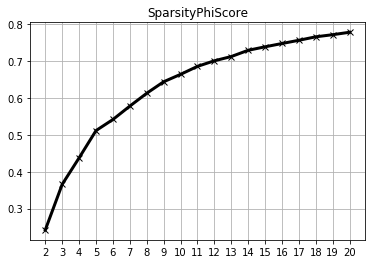

In [32]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [33]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [34]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9}

Text(0.5, 1.0, 'SparsityThetaScore')

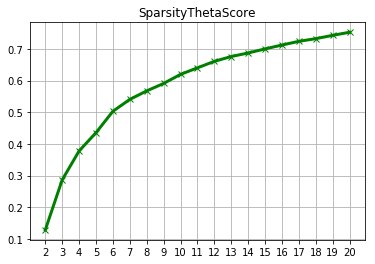

In [35]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [36]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [37]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 1, 0.5: 4, 0.6: 5, 0.7: 6}

Text(0.5, 1.0, 'PerplexityScore')

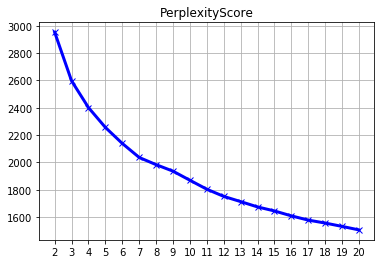

In [38]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [39]:
perplexity

[2952.2138671875,
 2596.471923828125,
 2400.96337890625,
 2255.84228515625,
 2138.655029296875,
 2036.177734375,
 1983.5289306640625,
 1935.8751220703125,
 1869.334716796875,
 1803.82275390625,
 1751.455078125,
 1713.245849609375,
 1674.34912109375,
 1644.8966064453125,
 1608.896728515625,
 1577.920654296875,
 1556.3575439453125,
 1531.8033447265625,
 1506.21630859375]

### select the best model

In [45]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 1, 0.5: 4, 0.6: 5, 0.7: 6}


In [66]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


---

In [21]:
select_topics = 20

model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# regularizers
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()


	SparsityThetaScore: 0.7527713775634766
	SparsityPhiScore: 0.7810007929801941
	PerplexityScore: 1491.50146484375


---

### print top words for each topics

In [22]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['транспорт' 'ведомство' 'запрет' 'федеральный' 'росавиация' 'решение'
 'авиалиния' 'министерство' 'гражданский' 'минтранс']
topic_1: ['ресторан' 'хороший' 'мероприятие' 'фестиваль' 'заведение' 'гость'
 'блюдо' 'премия' 'участие' 'конкурс']
topic_2: ['рейтинг' 'войти' 'исследование' 'занять' 'хороший' 'опрос' 'топ'
 'строчка' 'респондент' 'позиция']
topic_3: ['крым' 'регион' 'глава' 'развитие' 'ростуризм' 'чиновник' 'миллиард'
 'полуостров' 'край' 'министр']
topic_4: ['виза' 'документ' 'посольство' 'визовый' 'режим' 'въезд' 'оформление'
 'паспорт' 'шенгенский' 'срок']
topic_5: ['километр' 'поезд' 'метр' 'высота' 'экспедиция' 'путь' 'маршрут' 'рекорд'
 'час' 'минута']
topic_6: ['клиент' 'тур' 'путёвка' 'союз' 'фирма' 'туриндустрия' 'турфирма'
 'деньга' 'рст' 'финансовый']
topic_7: ['шар' 'американский' 'жизнь' 'очень' 'кампания' 'хотеть' 'отпуск'
 'граница' 'собираться' 'житель']
topic_8: ['область' 'маршрут' 'экскурсия' 'пункт' 'отправиться' 'автомобиль'
 'машина' 'побывать' '

In [31]:
# save to json

outjson = {}
# ---
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        #print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])
        outjson[f'{col}'] = phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:20]

In [32]:
import pickle

with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'wb') as handle:
    pickle.dump(outjson, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'rb') as handle:
    out_picle = pickle.load(handle)
    
out_picle

{'topic_0': array(['транспорт', 'ведомство', 'запрет', 'федеральный', 'росавиация',
        'решение', 'авиалиния', 'министерство', 'гражданский', 'минтранс',
        'разрешение', 'перевозка', 'проверка', 'авиация', 'жуковский',
        'ограничение', 'сторона', 'запретить', 'авиационный', 'закон'],
       dtype=object),
 'topic_1': array(['ресторан', 'хороший', 'мероприятие', 'фестиваль', 'заведение',
        'гость', 'блюдо', 'премия', 'участие', 'конкурс', 'кухня',
        'airbnb', 'рамка', 'организатор', 'прессрелиз', 'hotel',
        'поступить', 'world', 'предложить', 'шефповар'], dtype=object),
 'topic_2': array(['рейтинг', 'войти', 'исследование', 'занять', 'хороший', 'опрос',
        'топ', 'строчка', 'респондент', 'позиция', 'лидер', 'тройка',
        'достаться', 'опросить', 'европа', 'замыкать', 'попасть',
        'tripadvisor', 'третье', 'второе'], dtype=object),
 'topic_3': array(['крым', 'регион', 'глава', 'развитие', 'ростуризм', 'чиновник',
        'миллиард', 'полуо

### get topics-docs matrix

shape theta: (20, 8245)


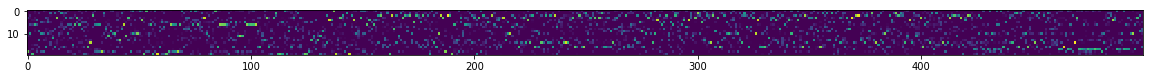

In [23]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [24]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
4000,0.0,0.000000,0.000000,0.062552,0.000000,0.106852,0.0,0.000000,0.0,0.329381,0.076133,0.0,0.062931,0.135334,0.000000,0.000000,0.188290,0.0,0.026638,0.011889
4001,0.0,0.000000,0.000000,0.212537,0.570921,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.189796,0.026747,0.000000,0.000000,0.0,0.000000,0.000000
4002,0.0,0.192172,0.000000,0.107643,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.008902,0.302641,0.000000,0.114917,0.273725,0.0,0.000000,0.000000
4003,0.0,0.090836,0.637132,0.000000,0.000000,0.000000,0.0,0.078615,0.0,0.000000,0.000000,0.0,0.193418,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4004,0.0,0.172602,0.348977,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.099004,0.073260,0.000000,0.096167,0.209989,0.0,0.000000,0.000000


## DataViz

In [25]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.321609,0.000000,...,0.053078,0.000000,0.000000,0.000000,0.088315,0.036921,0.000000,0.0,0.000000,0.000000
1,1,1999,10,0.000000,0.013917,0.000000,0.119639,0.000000,0.218978,0.000000,...,0.019544,0.120043,0.000000,0.126859,0.000000,0.000000,0.190091,0.0,0.190929,0.000000
2,2,1999,12,0.000000,0.047422,0.014742,0.104531,0.110654,0.036588,0.000000,...,0.000000,0.000000,0.043287,0.000000,0.000000,0.000000,0.601491,0.0,0.000000,0.000000
3,3,1999,11,0.322959,0.000000,0.000000,0.000000,0.511585,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.080105,0.000000
4,4,2000,1,0.000000,0.000000,0.085221,0.271810,0.000000,0.049493,0.035064,...,0.000000,0.000000,0.131735,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.044315


In [26]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (223, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 10     0.000000  0.013917  0.000000  0.119639  0.000000  0.540586   
     11     0.322959  0.000000  0.000000  0.000000  0.511585  0.000000   
     12     0.000000  0.047422  0.014742  0.104531  0.110654  0.036588   
2000 1      0.000000  0.000000  0.850304  0.271810  0.000000  0.057026   
     3      1.551974  0.472238  0.382186  0.582986  0.241241  0.000000   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 10     0.000000  0.199914  0.163964  0.136198  0.072623  0.120043   
     11     0.000000  0.085352  0.000000  0.000000  0.000000  0.000000   
     12     0.000000  0.000000  0.041285  0.000000  0.000000  0.000000   
2000 1      0.035064  0.227385  0.000000  0.382363  0.000000  0.000000   
     3      0.315035  0.205486  0.003749  0.138837  0.391625  0.580271   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 10     0.000000  0.126859  0.088315  0.036921  0.190091  0.000000   
     11     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     12     0.043287  0.000000  0.000000  0.000000  0.601491  0.000000   
2000 1      0.131735  0.000000  0.000000  0.000000  0.000000  0.000000   
     3      0.000000  0.612090  0.179497  0.059818  0.016515  0.001093   

            topic_18  topic_19  
year month                      
1999 10     0.190929  0.000000  
     11     0.080105  0.000000  
     12     0.000000  0.000000  
2000 1      0.000000  0.044315  
     3      0.162688  0.102672

### straightforward matrix heatmap

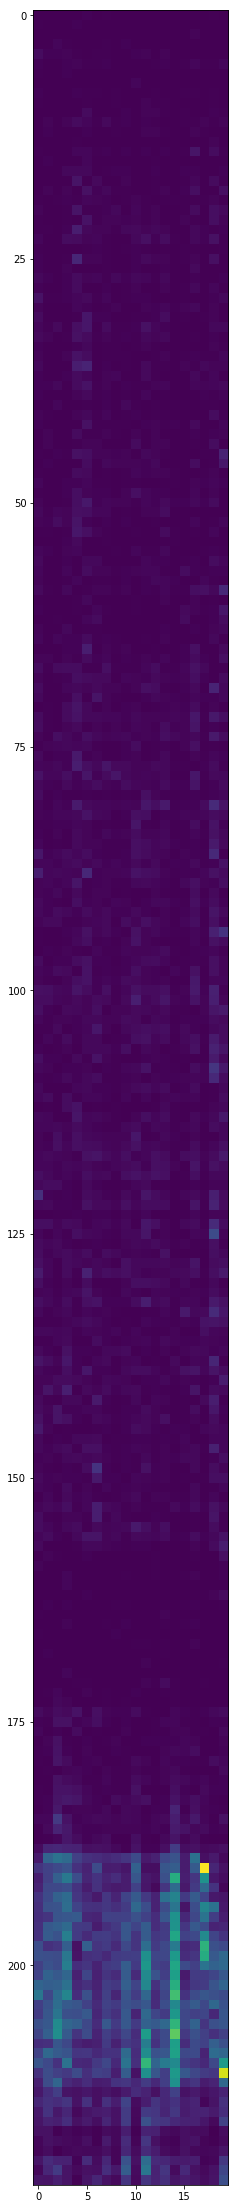

In [27]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [72]:
import pygal
from IPython.display import SVG, HTML

In [73]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [75]:
line_chart.render_to_file(f'data/visualization/{name_dataset}_pygal.svg')

## joypy

In [76]:
import joypy # !pip install joypy

In [28]:
print(joined.shape)
joined.head()

(8245, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.321609,0.000000,...,0.053078,0.000000,0.000000,0.000000,0.088315,0.036921,0.000000,0.0,0.000000,0.000000
1,1,1999,10,0.000000,0.013917,0.000000,0.119639,0.000000,0.218978,0.000000,...,0.019544,0.120043,0.000000,0.126859,0.000000,0.000000,0.190091,0.0,0.190929,0.000000
2,2,1999,12,0.000000,0.047422,0.014742,0.104531,0.110654,0.036588,0.000000,...,0.000000,0.000000,0.043287,0.000000,0.000000,0.000000,0.601491,0.0,0.000000,0.000000
3,3,1999,11,0.322959,0.000000,0.000000,0.000000,0.511585,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.080105,0.000000
4,4,2000,1,0.000000,0.000000,0.085221,0.271810,0.000000,0.049493,0.035064,...,0.000000,0.000000,0.131735,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.044315


In [29]:
joined.to_csv(f'./data/topicsProbability/{name_dataset}.csv',index=False)

In [78]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.080039,0.0,0.000000,0.0,0.00000,0.000000,1999-10-01
1,1,1,1999,10,0.0000,0.000000,0.0,0.181925,0.000000,0.373178,...,0.067121,0.000000,0.102151,0.000000,0.0,0.159073,0.0,0.01806,0.000000,1999-10-01
2,2,2,1999,12,0.0000,0.042791,0.0,0.121397,0.066537,0.025010,...,0.000000,0.027667,0.000000,0.000000,0.0,0.595710,0.0,0.00000,0.000000,1999-12-01
3,3,3,1999,11,0.0617,0.000000,0.0,0.081972,0.545477,0.000000,...,0.000000,0.119473,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,1999-11-01
4,4,4,2000,1,0.0000,0.084570,0.0,0.162722,0.000000,0.062985,...,0.000000,0.000000,0.000000,0.019863,0.0,0.000000,0.0,0.00000,0.018414,2000-1-01


In [79]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(197880, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-12-01,index,2.0
3,1999-11-01,index,3.0
4,2000-1-01,index,4.0


In [80]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(164900, 3)


topic_8     8245
topic_19    8245
topic_3     8245
topic_1     8245
topic_17    8245
topic_11    8245
topic_7     8245
topic_6     8245
topic_4     8245
topic_18    8245
topic_15    8245
topic_13    8245
topic_5     8245
topic_10    8245
topic_0     8245
topic_9     8245
topic_12    8245
topic_16    8245
topic_2     8245
topic_14    8245
Name: topic, dtype: int64

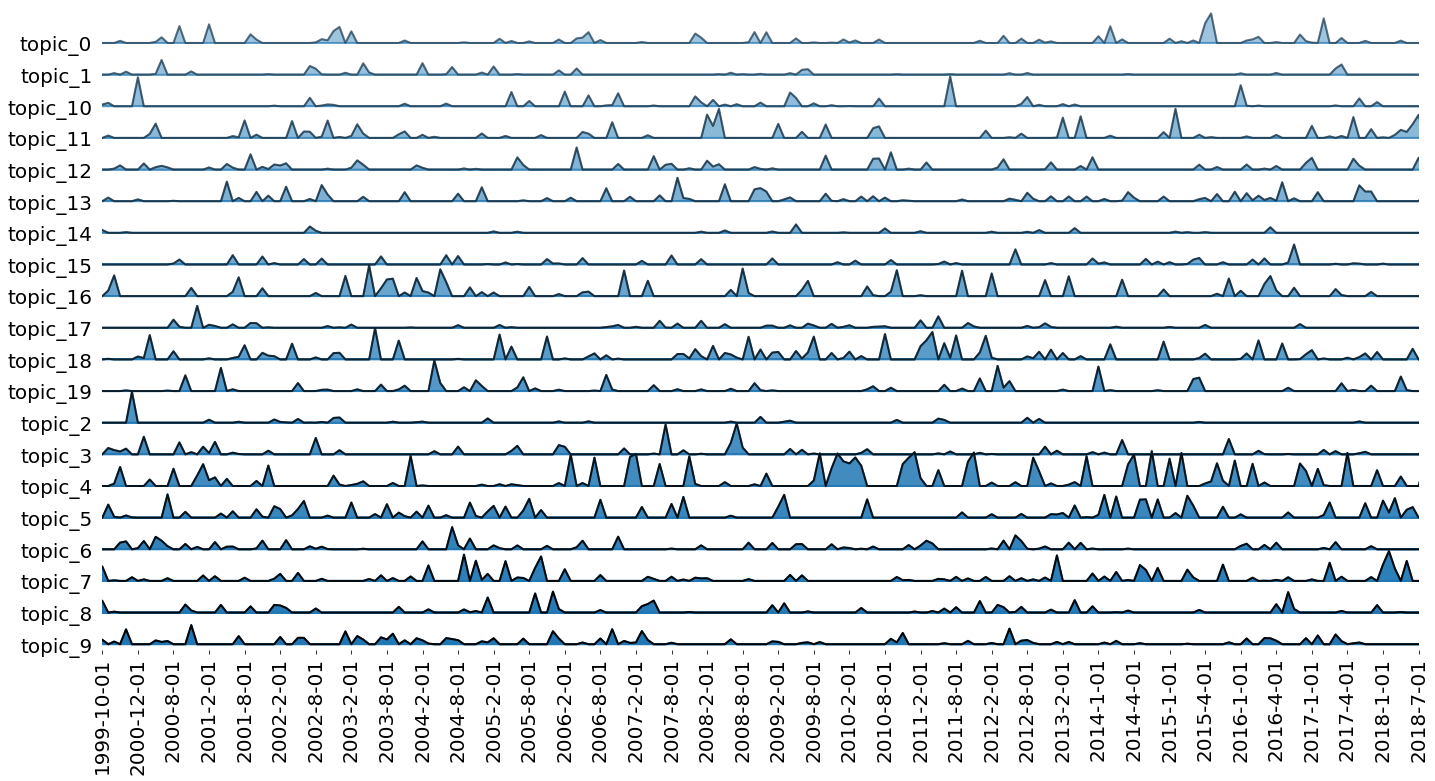

In [81]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [82]:
fig.savefig(f'data/visualization/{name_dataset}_joypy')